In [170]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 999)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.special import boxcox1p
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso, LassoCV
import os
import warnings
warnings.filterwarnings('ignore')

In [171]:
train = pd.read_csv('train.csv')

In [172]:
test = pd.read_csv('test.csv')

In [173]:
test2 = pd.read_csv('test.csv')

In [174]:
train.describe(include='all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1452,1452.000000,1460,1460,1460,1423,1423,1422,1423,1460.000000,1422,1460.000000,1460.000000,1460.000000,1460,1460,1460,1459,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000,1460,1460.000000,770,1379,1379.000000,1379,1460.000000,1460.000000,1379,1379,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,4,NaN,4,5,6,4,4,4,6,NaN,6,NaN,NaN,NaN,6,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,5,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,NaN,NaN,NaN,NaN,1141,1434,515,504,864,NaN,906,1282,647,649,1311,953,430,NaN,1256,NaN,NaN,NaN,1428,741,1365,1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735,NaN,1360,NaN,380,870,NaN,605,NaN,NaN,1311,1326,1340,NaN,NaN,NaN,NaN,NaN,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099315,5.575342,1971.267808,1984.865753,NaN,NaN,NaN,NaN,NaN,103.685262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.639726,NaN,46.549315,567.240411,1057.429452,NaN,NaN,NaN,NaN,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,NaN,6.517808,NaN,0.613014,NaN,NaN,1978.506164,NaN,1.767123,472.980137,NaN,NaN,NaN,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.382997,1.112799,30.202904,20.645407,NaN,NaN,NaN,NaN,NaN,181.066207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098091,NaN,161.319273,441.866955,438.705324,NaN,NaN,NaN,NaN,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,NaN,1.625393,NaN,0.644666,NaN,NaN,24.689725,NaN,0.747315,213.804841,NaN,NaN,NaN,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,NaN,1900.000000,NaN

In [175]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

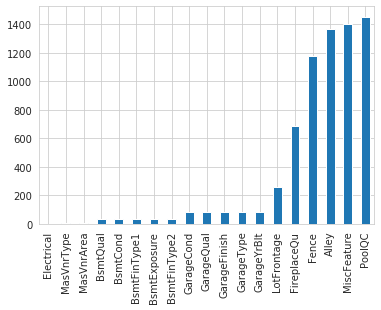

In [176]:
sns.set_style("whitegrid")
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [177]:
missing

Electrical         1
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
BsmtExposure      38
BsmtFinType2      38
GarageCond        81
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
LotFrontage      259
FireplaceQu      690
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64

In [178]:
houses=pd.concat([train,test], sort=False)

In [179]:
for col in ('Alley','Utilities','MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
            'BsmtFinType2','Electrical','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
           'PoolQC','Fence','MiscFeature'):
    train[col]=train[col].fillna('None')
    test[col]=test[col].fillna('None')

In [180]:
for col in ('MSZoning','Exterior1st','Exterior2nd','KitchenQual','SaleType','Functional'):
    train[col]=train[col].fillna(train[col].mode()[0])
    test[col]=test[col].fillna(train[col].mode()[0])

In [181]:
for col in ('MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','GarageYrBlt','GarageCars','GarageArea'):
    train[col]=train[col].fillna(0)
    test[col]=test[col].fillna(0)

In [182]:
train['LotFrontage']=train['LotFrontage'].fillna(train['LotFrontage'].mean())
test['LotFrontage']=test['LotFrontage'].fillna(train['LotFrontage'].mean())

In [183]:
print(train.isnull().sum().sum())
print(train.isnull().sum().sum())

0
0


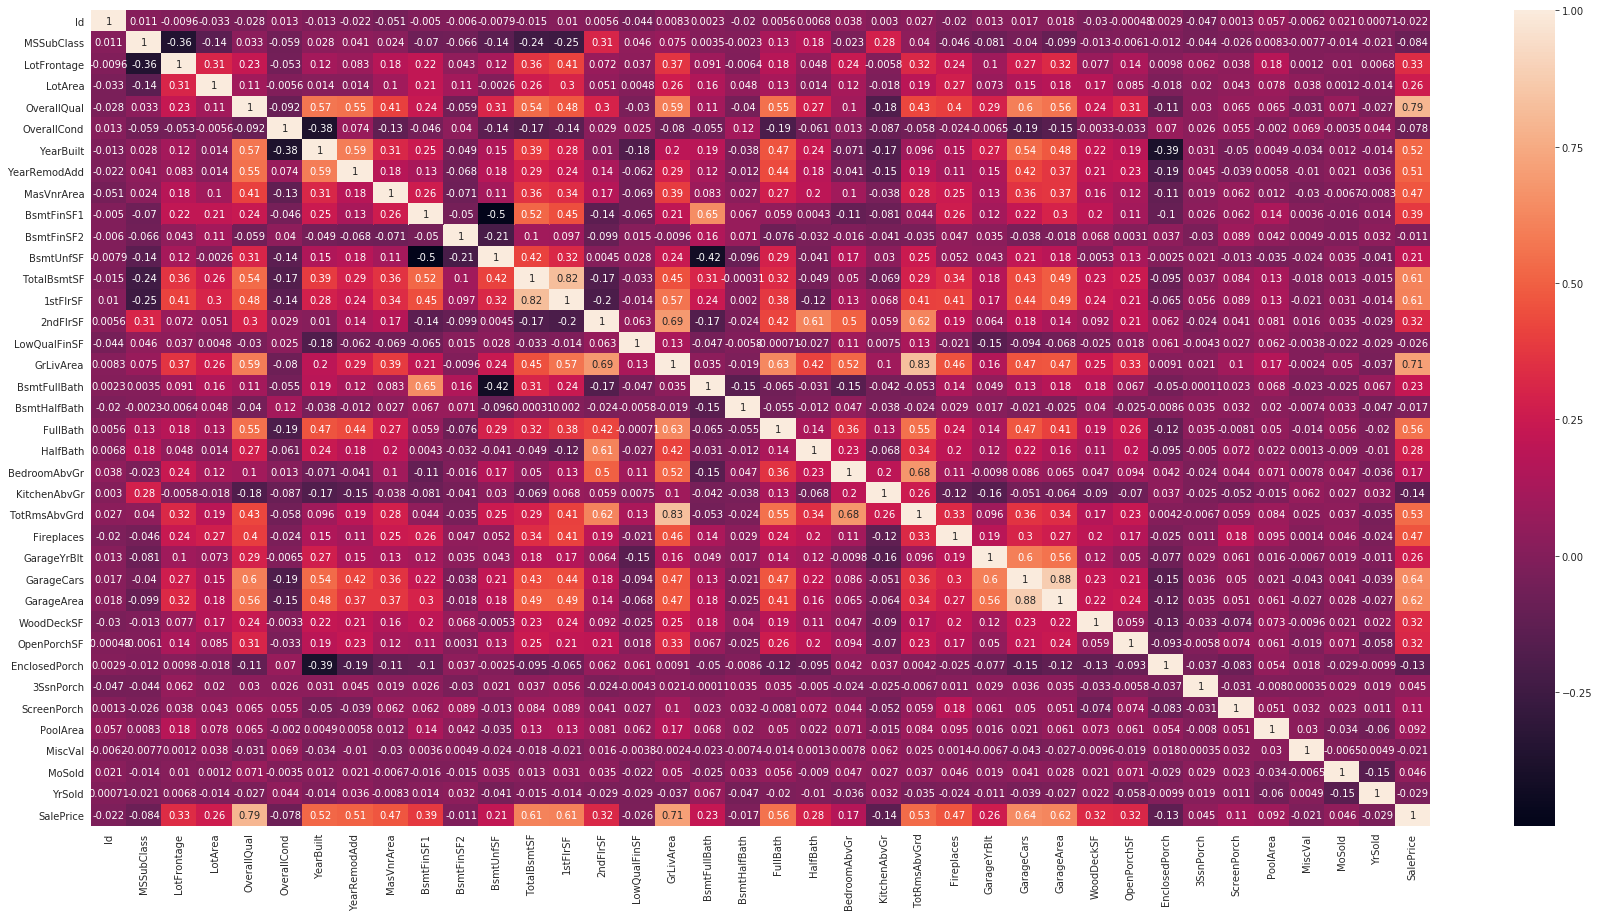

In [184]:
plt.figure(figsize=[30,15])
sns.heatmap(train.corr(), annot=True)

In [185]:
train.drop(['GarageArea','1stFlrSF','TotRmsAbvGrd','2ndFlrSF'], axis=1, inplace=True)
test.drop(['GarageArea','1stFlrSF','TotRmsAbvGrd','2ndFlrSF'], axis=1, inplace=True)

In [186]:
train = train[train['GrLivArea']<4000]

In [187]:
len_train=train.shape[0]
print(train.shape)

(1456, 77)


In [188]:
houses=pd.concat([train,test], sort=False)

In [189]:
houses['MSSubClass']=houses['MSSubClass'].astype(str)

In [190]:
skew=houses.select_dtypes(include=['int','float']).apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skew_df=pd.DataFrame({'Skew':skew})
skewed_df=skew_df[(skew_df['Skew']>0.5)|(skew_df['Skew']<-0.5)]

In [191]:
lam=0.1
for col in ('MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
       'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch',
       'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF',
       'LotFrontage', 'GrLivArea', 'BsmtFinSF1', 'BsmtUnfSF', 'Fireplaces',
       'HalfBath', 'TotalBsmtSF', 'BsmtFullBath', 'OverallCond', 'YearBuilt',
       'GarageYrBlt'):
    train[col]=boxcox1p(train[col],lam)
    test[col]=boxcox1p(test[col],lam)

In [192]:
train['SalePrice']=np.log(train['SalePrice'])

In [193]:
houses=pd.concat([train,test], sort=False)
houses=pd.get_dummies(houses)

In [194]:
train=houses[:len_train]
test=houses[len_train:]

In [195]:
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

In [196]:
x=train.drop('SalePrice', axis=1)
y=train['SalePrice']
test=test.drop('SalePrice', axis=1)

In [197]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.14.0


In [198]:
train_labels = y

In [199]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(x.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [200]:
model = build_model()

In [201]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                19200     
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 23,425
Trainable params: 23,425
Non-trainable params: 0
_________________________________________________________________


In [202]:
example_batch = x[:10]
example_result = model.predict(example_batch)
example_result

array([[115.44537 ],
       [114.93753 ],
       [116.0936  ],
       [116.44148 ],
       [115.82712 ],
       [116.532326],
       [114.094536],
       [116.151085],
       [117.2561  ],
       [122.77587 ]], dtype=float32)

In [203]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  x, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................

In [204]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
95,0.254215,0.460138,0.254215,0.205781,0.415077,0.205781,95
96,0.230704,0.434662,0.230704,0.255940,0.471435,0.255940,96
97,0.254907,0.468343,0.254907,0.412695,0.613888,0.412695,97
98,0.256000,0.462544,0.256000,0.175636,0.380731,0.175636,98
99,0.232610,0.416890,0.232610,0.340444,0.553133,0.340444,99


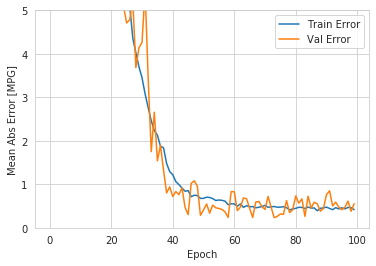

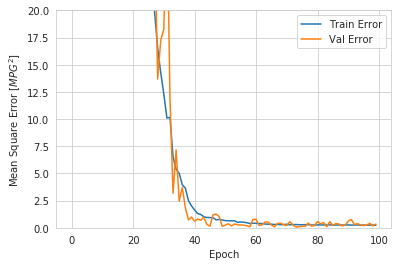

In [205]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


...............................................

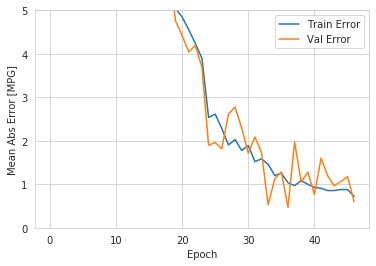

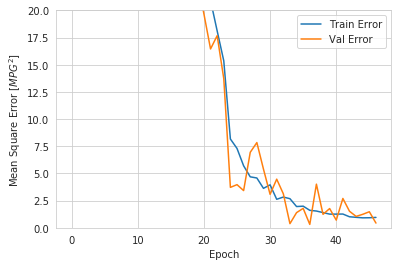

In [207]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(x, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [208]:
pred=model.predict(test)
preds=np.exp(pred)

In [216]:
output = pd.DataFrame({'Id': test2.Id, 'SalePrice': preds[:, 0]})

In [219]:
output.to_csv('submission.csv', index=False)